In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from collections import defaultdict
from copy import deepcopy

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) == 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [4]:
convert_sbml_to_network('BIOMD0000000011.xml')

number reactions 30
number species 22


In [5]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [6]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways2'
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000011.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [7]:
generate_test_set('BIOMD0000000011.xml', description)

In [2]:
description_path = 'altered_pathways2/reaction11/description'
description_file = open(description_path, 'rb')
temp = pickle.load(description_file)
description_file.close()
temp

{'species': ['MAPK',
  'MAPKMEKpp',
  'MAPKp',
  'MAPKPH',
  'MAPKpMAPKPH',
  'MAPKpMEKpp',
  'MAPKpp',
  'MAPKppMAPKPH',
  'MEK',
  'MEKp',
  'MEKPH',
  'MEKpMEKPH',
  'MEKpp',
  'MEKppMEKPH',
  'MEKpRAFp',
  'MEKRAFp',
  'RAF',
  'RAFK',
  'RAFp',
  'RAFPH',
  'RAFpRAFPH',
  'RAFRAFK'],
 'reactions': [['Reaction1', 0, 1],
  ['Reaction2', 0, 1],
  ['Reaction3', 0, 1],
  ['Reaction4', 0, 1],
  ['Reaction5', 0, 1],
  ['Reaction6', 0, 1],
  ['Reaction7', 0, 1],
  ['Reaction8', 0, 1],
  ['Reaction9', 0, 1],
  ['Reaction10', 0, 1],
  ['Reaction11', 0, 1],
  ['Reaction12', 0, 1],
  ['Reaction13', 0, 1],
  ['Reaction14', 0, 1],
  ['Reaction15', 0, 1],
  ['Reaction16', 0, 1],
  ['Reaction17', 0, 1],
  ['Reaction18', 0, 1],
  ['Reaction19', 0, 1],
  ['Reaction20', 0, 1],
  ['Reaction21', 0, 1],
  ['Reaction22', 0, 1],
  ['Reaction23', 0, 1],
  ['Reaction24', 0, 1],
  ['Reaction25', 0, 1],
  ['Reaction26', 0, 1],
  ['Reaction27', 0, 1],
  ['Reaction28', 0, 1],
  ['Reaction29', 0, 1],
  ['Reacti

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000011.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 682.0
Converged at time 783.0
Specie:  MAPK expected result:  increased  normal final:  0.2586062680583866  altered final:  0.3283508645707652
confidence interval:  [0.9997684038148241, 0.9998038250788548]
deltas coming from simulation:  [0.06974459651237858, 0]
Specie:  MAPKMEKpp expected result:  increased  normal final:  0.05391240954065411  altered final:  0.06445412300013284
confidence interval:  [0.6862252647823168, 0.6954409420967564]
deltas coming from simulation:  [0.010541713459478727, 0]
Specie:  MAPKp expected result:  decreased  normal final:  0.022330234756784202  altered final:  0.00449167041293375
confidence interval:  [0.2493884910786482, 0.26756462493868266]
deltas coming from simulation:  [-0.017838564343850453, 0]
Specie:  MAPKPH expected result:  increased  normal final:  0.24143234184518705  altered final:  0.2984737596796804
confidence interval:  [0.974985595878522, 0.9771417380214776]
deltas coming from simulation:  [0.05704141783449332, 0]
Spe

In [3]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.703030303030303


In [4]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  660  correct:  464  uncertain:  0  true pos:  228  true neg:  236  false_pos:  105 false neg:  91


In [4]:
scores

[0.5454545454545454,
 0.7272727272727273,
 0.8181818181818182,
 0.7727272727272727,
 0.4090909090909091,
 0.5909090909090909,
 0.7727272727272727,
 0.7727272727272727,
 0.45454545454545453,
 0.8181818181818182,
 0.5454545454545454,
 0.7272727272727273,
 0.5909090909090909,
 0.8181818181818182,
 0.7272727272727273,
 0.7727272727272727,
 0.7727272727272727,
 0.7272727272727273,
 0.8181818181818182,
 0.7272727272727273,
 0.7272727272727273,
 0.8636363636363636,
 0.7272727272727273,
 0.7727272727272727,
 0.45454545454545453,
 0.7272727272727273,
 0.7727272727272727,
 0.4090909090909091,
 0.7272727272727273,
 0.8181818181818182]

In [10]:
print(
    'true positives: ', true_positives,
    'true negatives: ', true_negatives,
    'false positives: ', false_positives,
    'false negatives: ', false_negatives,
)

true positives:  254 true negatives:  269 false positives:  59 false negatives:  49


In [7]:
description['altered'] = 'Reaction1'
description

{'species': ['MAPK',
  'MAPKMEKpp',
  'MAPKp',
  'MAPKPH',
  'MAPKpMAPKPH',
  'MAPKpMEKpp',
  'MAPKpp',
  'MAPKppMAPKPH',
  'MEK',
  'MEKp',
  'MEKPH',
  'MEKpMEKPH',
  'MEKpp',
  'MEKppMEKPH',
  'MEKpRAFp',
  'MEKRAFp',
  'RAF',
  'RAFK',
  'RAFp',
  'RAFPH',
  'RAFpRAFPH',
  'RAFRAFK'],
 'reactions': [['Reaction1', 0, 1],
  ['Reaction2', 0, 1],
  ['Reaction3', 0, 1],
  ['Reaction4', 0, 1],
  ['Reaction5', 0, 1],
  ['Reaction6', 0, 1],
  ['Reaction7', 0, 1],
  ['Reaction8', 0, 1],
  ['Reaction9', 0, 1],
  ['Reaction10', 0, 1],
  ['Reaction11', 0, 1],
  ['Reaction12', 0, 1],
  ['Reaction13', 0, 1],
  ['Reaction14', 0, 1],
  ['Reaction15', 0, 1],
  ['Reaction16', 0, 1],
  ['Reaction17', 0, 1],
  ['Reaction18', 0, 1],
  ['Reaction19', 0, 1],
  ['Reaction20', 0, 1],
  ['Reaction21', 0, 1],
  ['Reaction22', 0, 1],
  ['Reaction23', 0, 1],
  ['Reaction24', 0, 1],
  ['Reaction25', 0, 1],
  ['Reaction26', 0, 1],
  ['Reaction27', 0, 1],
  ['Reaction28', 0, 1],
  ['Reaction29', 0, 1],
  ['Reacti

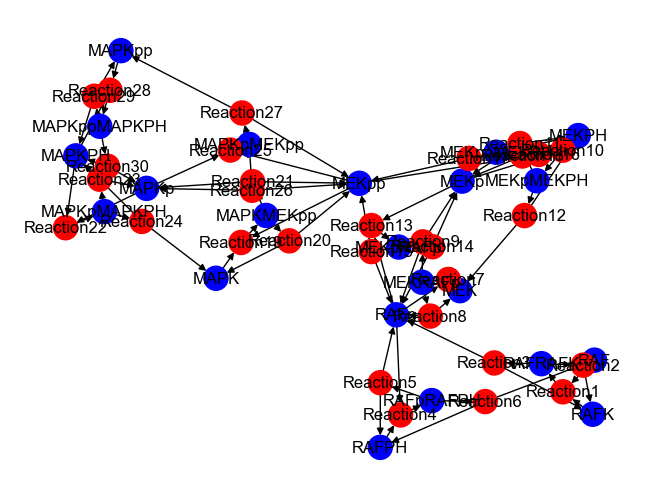

In [8]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [9]:
description_path = 'description_reaction1_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

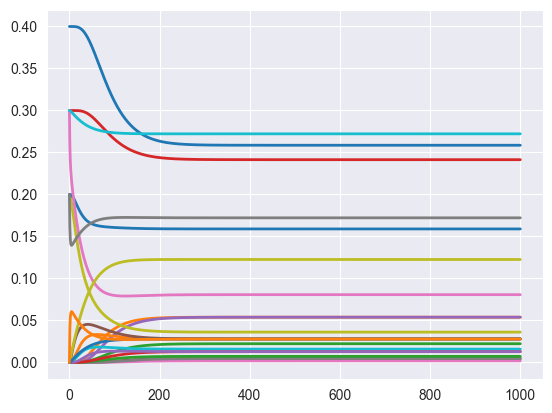

       time,   [MAPK], [MAPKMEKpp],     [MAPKp], [MAPKPH], [MAPKpMAPKPH], [MAPKpMEKpp],    [MAPKpp], [MAPKppMAPKPH],     [MEK],      [MEKp],  [MEKPH], [MEKpMEKPH],     [MEKpp], [MEKppMEKPH],  [MEKpRAFp],   [MEKRAFp],     [RAF],   [RAFK],     [RAFp],  [RAFPH], [RAFpRAFPH], [RAFRAFK]
 [[       0,      0.4,           0,           0,      0.3,             0,            0,           0,              0,       0.2,           0,      0.2,           0,           0,            0,           0,           0,       0.3,      0.2,          0,      0.3,           0,         0],
  [   1.001,      0.4, 4.35966e-11,  4.4088e-13,      0.3,   6.61054e-14,  2.39439e-23, 1.31786e-25,    1.08762e-26,  0.199606, 7.66193e-06, 0.199997, 2.97182e-06, 4.45493e-11,   1.0667e-11, 6.92865e-09, 0.000383563,  0.259465, 0.161685, 0.00175088, 0.299914, 8.55333e-05, 0.0383154],
  [   2.002,      0.4, 5.85462e-09, 1.14014e-10,      0.3,   3.57192e-11,  8.60658e-19, 9.57297e-21,    1.67181e-21,  0.197985, 6.61017e-05, 0.1999

In [10]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000011.xml')

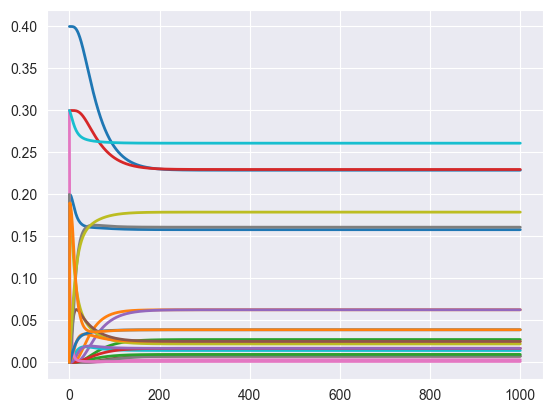

       time,   [MAPK], [MAPKMEKpp],     [MAPKp], [MAPKPH], [MAPKpMAPKPH], [MAPKpMEKpp],    [MAPKpp], [MAPKppMAPKPH],     [MEK],      [MEKp],  [MEKPH], [MEKpMEKPH],     [MEKpp], [MEKppMEKPH],  [MEKpRAFp],  [MEKRAFp],      [RAF],    [RAFK],    [RAFp],  [RAFPH], [RAFpRAFPH], [RAFRAFK]
 [[       0,      0.4,           0,           0,      0.3,             0,            0,           0,              0,       0.2,           0,      0.2,           0,           0,            0,           0,          0,        0.3,       0.2,         0,      0.3,           0,         0],
  [   1.001,      0.4, 7.25567e-09, 8.68394e-11,      0.3,   1.53085e-11,  7.69085e-19, 4.98684e-21,    4.80692e-22,  0.195997, 9.21819e-05, 0.199958, 4.21617e-05, 6.02752e-09,  1.76762e-09, 8.32634e-07, 0.00386768,  0.0920205, 0.0101288, 0.0133739, 0.299134, 0.000865865,  0.189871],
  [   2.002,      0.4, 3.48864e-07, 7.93347e-09,      0.3,   2.92897e-09,  3.57554e-15, 4.69588e-17,    9.73494e-18,  0.187638, 0.000466279, 0.1996

In [11]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000011_reaction1_100x.xml')

In [12]:
species = description['species']
species

['MAPK',
 'MAPKMEKpp',
 'MAPKp',
 'MAPKPH',
 'MAPKpMAPKPH',
 'MAPKpMEKpp',
 'MAPKpp',
 'MAPKppMAPKPH',
 'MEK',
 'MEKp',
 'MEKPH',
 'MEKpMEKPH',
 'MEKpp',
 'MEKppMEKPH',
 'MEKpRAFp',
 'MEKRAFp',
 'RAF',
 'RAFK',
 'RAFp',
 'RAFPH',
 'RAFpRAFPH',
 'RAFRAFK']

In [13]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [14]:
final_normal

[1.00000000e+03 2.58606264e-01 5.39124099e-02 2.23302356e-02
 2.41432339e-01 5.39124104e-02 4.65525003e-03 1.92818002e-03
 4.65525014e-03 3.61603803e-02 1.59279066e-02 1.58976250e-01
 2.81350984e-02 7.29655314e-03 1.28886517e-02 1.28886516e-02
 2.81350983e-02 8.07527965e-02 1.72190303e-01 1.22604060e-01
 2.72190303e-01 2.78096968e-02 2.78096970e-02]

In [15]:
temp = final_concentrations_normal[1]
temp

[0.4 0.  0.  0.3 0.  0.  0.  0.  0.2 0.  0.2 0.  0.  0.  0.  0.  0.3 0.2
 0.  0.3 0.  0. ]

In [16]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

MAPK
final normal:  0.2586062638620924 final altered:  0.22892506773288027 delta:  -0.029681196129212134 relative delta  -0.11477369374564067 initial concentration:  0.4 delta1 0.07420299032303034 delta2 0.11477369374564061
MAPKMEKpp
final normal:  0.05391240992900051 final altered:  0.06276036018439111 delta:  0.008847950255390605 relative delta  0.16411713494245272 initial concentration:  0.0 delta1 0 delta2 0.1641171349424526
MAPKp
final normal:  0.022330235643829608 final altered:  0.027316723154438706 delta:  0.004986487510609098 relative delta  0.22330653335433953 initial concentration:  0.0 delta1 0 delta2 0.2233065333543396
MAPKPH
final normal:  0.2414323394718488 final altered:  0.22975069330166495 delta:  -0.011681646170183857 relative delta  -0.04838476152672143 initial concentration:  0.3 delta1 0.03893882056727953 delta2 0.04838476152672144
MAPKpMAPKPH
final normal:  0.05391241037405346 final altered:  0.06276036089754138 delta:  0.008847950523487913 relative delta  0.1641

In [17]:
expected_results

{'MAPK': 'decreased',
 'MAPKMEKpp': 'increased',
 'MAPKp': 'increased',
 'MAPKPH': 'decreased',
 'MAPKpMAPKPH': 'increased',
 'MAPKpMEKpp': 'increased',
 'MAPKpp': 'increased',
 'MAPKppMAPKPH': 'increased',
 'MEK': 'decreased',
 'MEKp': 'decreased',
 'MEKPH': 'unchanged',
 'MEKpMEKPH': 'decreased',
 'MEKpp': 'increased',
 'MEKppMEKPH': 'increased',
 'MEKpRAFp': 'increased',
 'MEKRAFp': 'decreased',
 'RAF': 'decreased',
 'RAFK': 'decreased',
 'RAFp': 'increased',
 'RAFPH': 'decreased',
 'RAFpRAFPH': 'increased',
 'RAFRAFK': 'increased'}

In [17]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

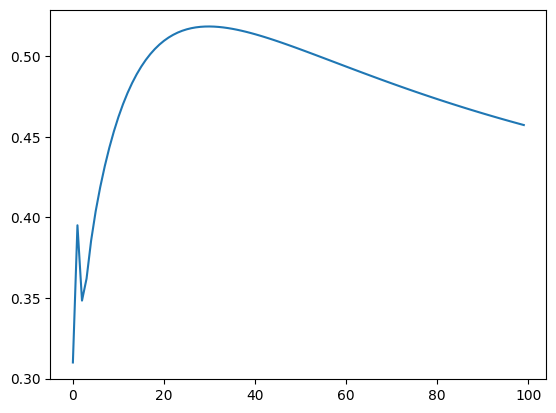

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [18]:
res = complete_tests.complete_tests2(
            'BIOMD0000000011.xml',
            'BIOMD0000000011_reaction1_100x.xml',
            'description_reaction1_altered',
            []
        )

In [19]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  MAPK expected result:  decreased
confidence interval:  [0.42923186218256776, 0.435668852765617]
Specie:  MAPKMEKpp expected result:  increased
confidence interval:  [0.5042792545153224, 0.5046908414420695]
Specie:  MAPKp expected result:  increased
confidence interval:  [0.48620162272160167, 0.48791061297685984]
Specie:  MAPKPH expected result:  decreased
confidence interval:  [0.509850316700095, 0.5113233348262696]
Specie:  MAPKpMAPKPH expected result:  increased
confidence interval:  [0.4993939680004625, 0.49968552201150657]
Specie:  MAPKpMEKpp expected result:  increased
confidence interval:  [0.5167179548390505, 0.5182550177929773]
Specie:  MAPKpp expected result:  increased
confidence interval:  [0.5446244215443393, 0.5495083244061735]
Specie:  MAPKppMAPKPH expected result:  increased
confidence interval:  [0.5133464778739144, 0.5148296143143075]
Specie:  MEK expected result:  decreased
confidence interval:  [0.36402328712334353, 0.3723023379803826]
Specie:  MEKp expected

In [20]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  22 correct experiments:  16 ratio:  0.7272727272727273


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

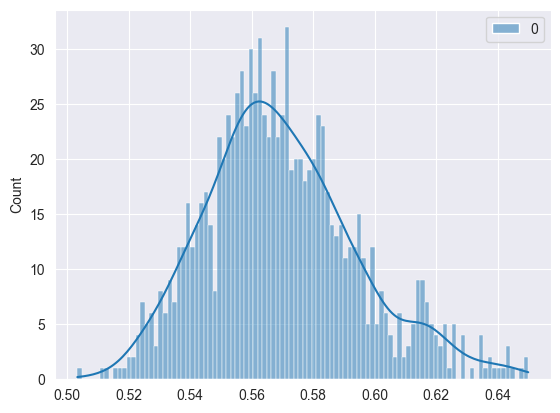

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)